**Brian Blaylock**  
**October 31, 2018**

# GOES-16 Cloud-Free Composite
Generate a GOES-16 image without clouds. This is compositing many RGB images and finding the lowest RGB value between all images.

- If the minimum RGB value between many is used, you get cloud shaddows. Instead, use the 5th percentile (the almost minimum).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_GOES.get_ABI import files_on_pando, get_GOES_FireTemperature, get_GOES_TrueColor
from BB_maps.my_basemap import draw_centermap, draw_HRRR_map, draw_GOES_East_geo

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [12,8]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 300

Makes some maps

In [2]:
# Geostationary CONUS
g = draw_GOES_East_geo()

In [3]:
# HRRR Domain
m = draw_HRRR_map()

In [4]:
# Western USA
w = draw_centermap(lat=40, lon=-112, size=[10,12])

In [5]:
# Utah
u = draw_centermap(lat=40, lon=-112, size=[4,4])

Specify the range of dates

In [6]:
sDATE = datetime(2018, 9, 1)
eDATE = datetime(2018, 10, 1)
DATES = [sDATE + timedelta(days=d) for d in range((eDATE-sDATE).days)]

In [7]:
FILES = np.array([])
for i in DATES:
    FILES = np.append(FILES, files_on_pando(i))

In [8]:
np.shape(FILES)

(8636,)

In [9]:
# Cut number of files based on time of day
cFILES = [i for i in FILES 
         if datetime.strptime(i.split('/')[-1].split('_')[3], 's%Y%j%H%M%S%f').hour==18 and
            datetime.strptime(i.split('/')[-1].split('_')[3], 's%Y%j%H%M%S%f').minute<20]

In [10]:
np.shape(cFILES)

(120,)

In [11]:
DIR = '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/'
ABI = get_GOES_FireTemperature(DIR+FILES[0], verbose=False)

In [12]:
composite = []

sub_FILES = cFILES[:]
num_FILES = len(sub_FILES)
print('Number of Files:', num_FILES)

for i, FILE in enumerate(sub_FILES):
    composite.append(get_GOES_TrueColor(DIR+FILE, return_dates=False, night_IR=False, return_latlon=False,verbose=False)['TrueColor Tuple'])
    sys.stdout.write("\r%.1f%%" % ((i+1)/num_FILES*100))
    sys.stdout.flush()

composite = np.array(composite)

Number of Files: 120
100.0%

In [13]:
percentile = 50
max_composite = np.percentile(composite, percentile, axis=0)
#max_composite = np.nanmin(composite,axis=0)
#max_composite = np.sqrt(np.nanmean(composite**2, axis=0))

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Percentile: 0


/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


Percentile: 1
Percentile: 2
Percentile: 3
Percentile: 4
Percentile: 5
Percentile: 25
Percentile: 50
Percentile: 75
Percentile: 95
Percentile: 100


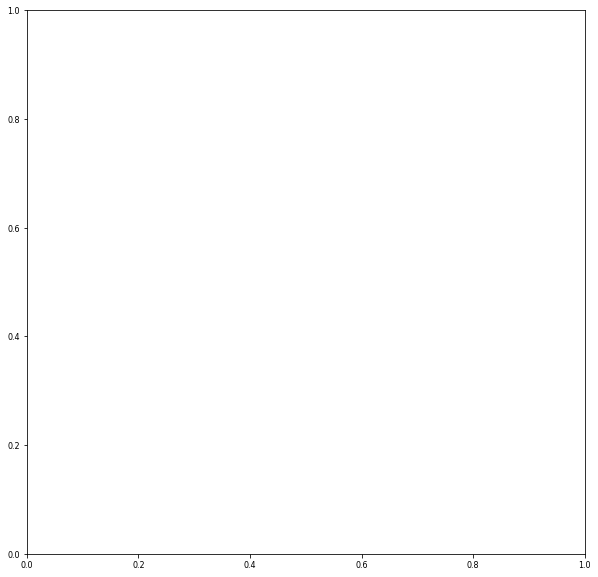

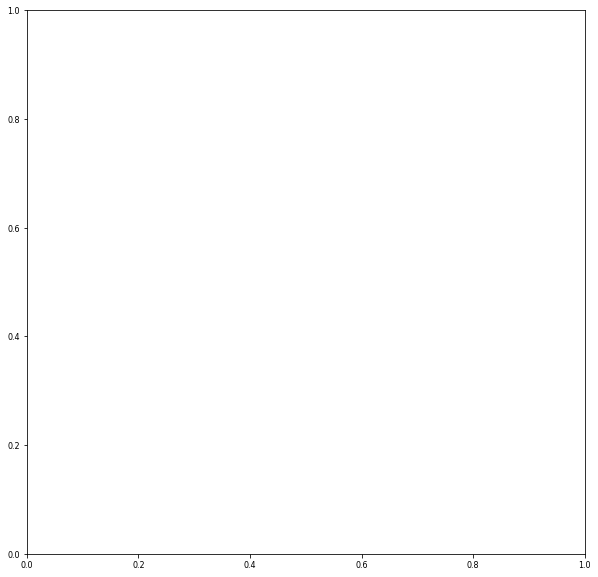

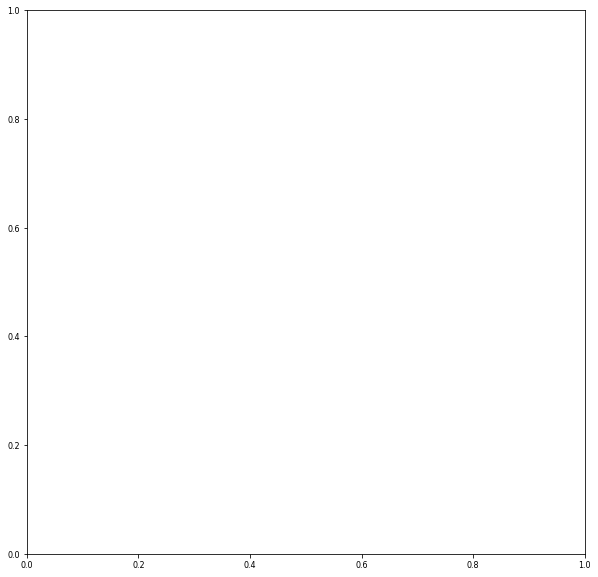

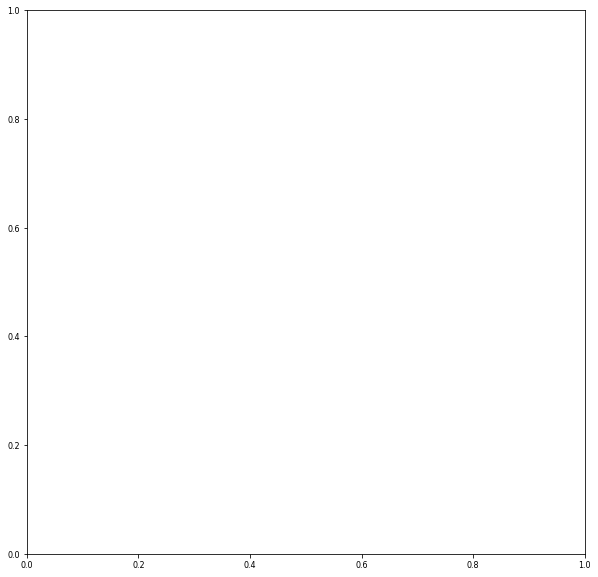

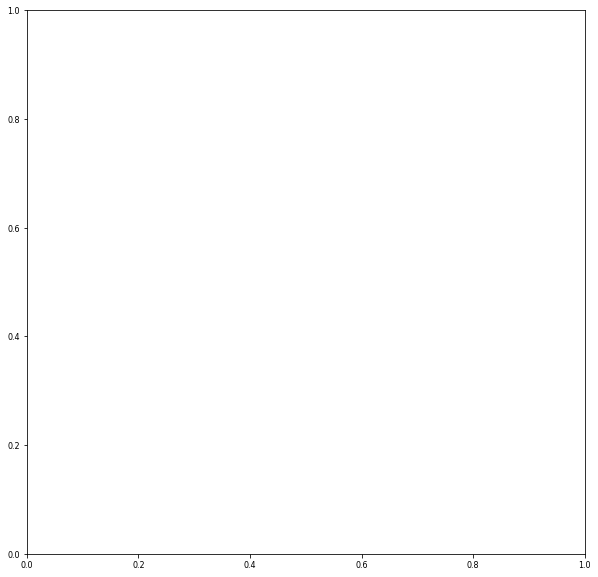

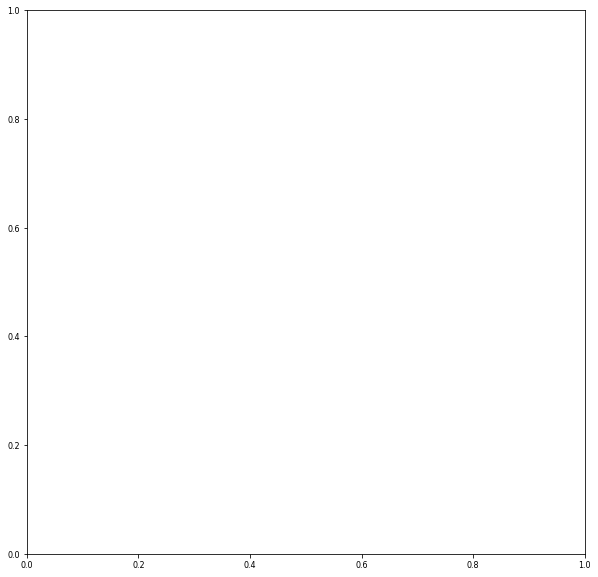

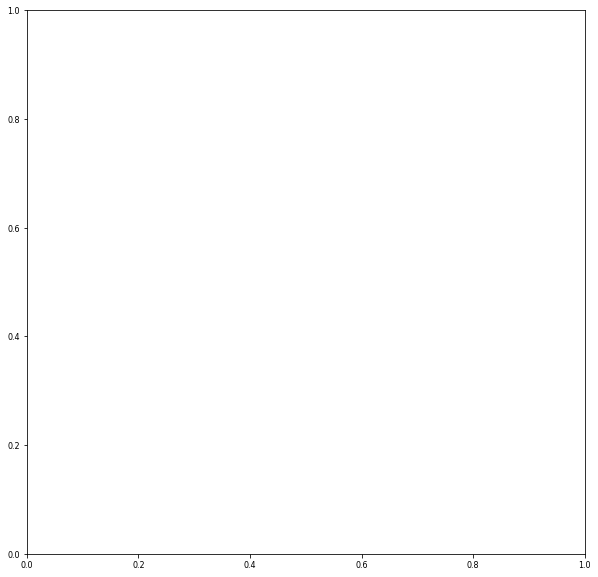

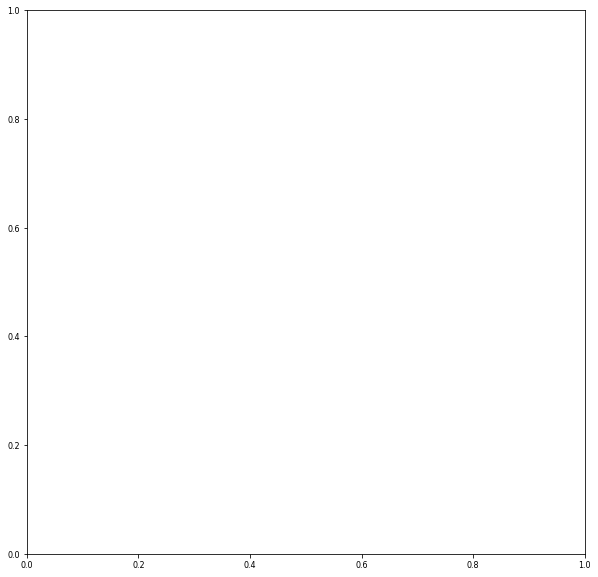

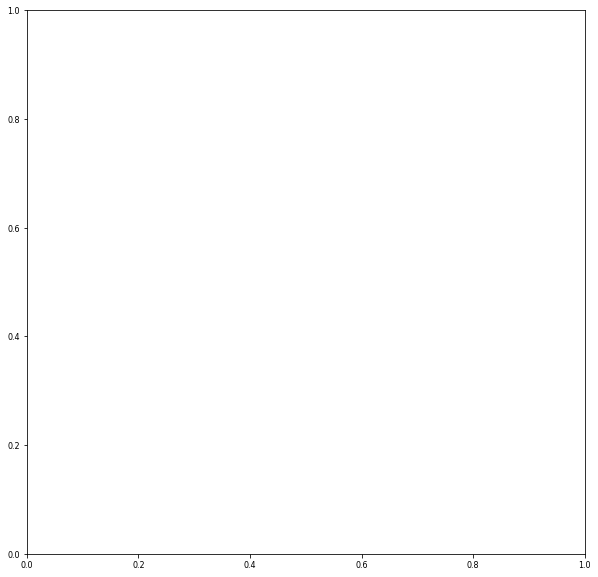

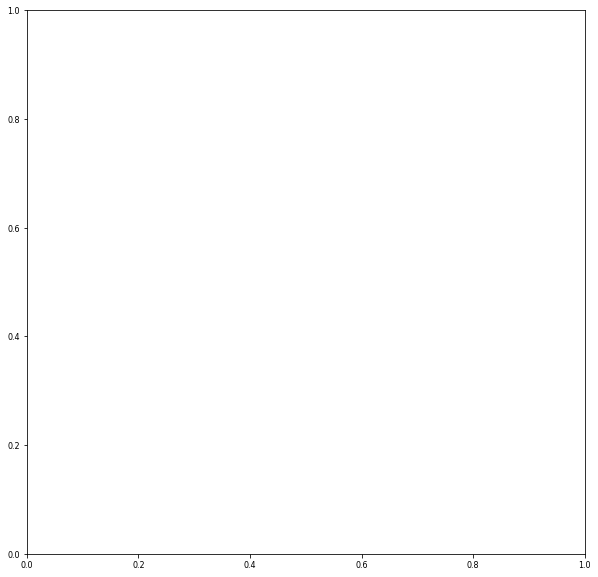

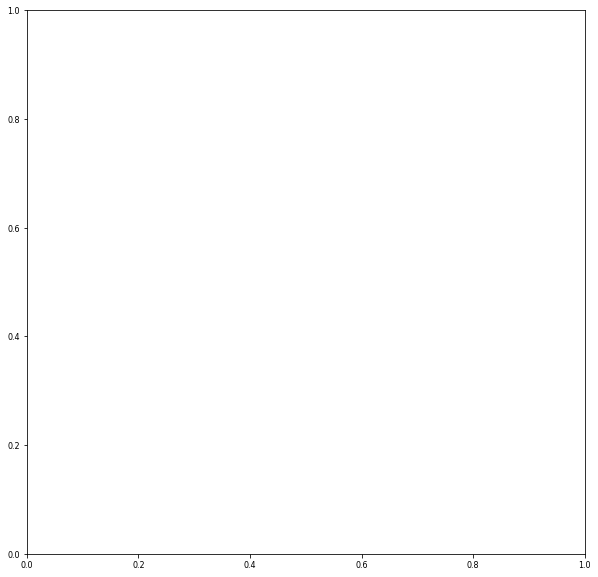

In [14]:
for percentile in [0, 1, 2, 3, 4, 5, 25, 50, 75, 95, 100]:
    print('Percentile:', percentile)
    max_composite = np.percentile(composite, percentile, axis=0)

    plt.figure(figsize=[10,10])
    newmap = m.pcolormesh(ABI['lon'], ABI['lat'], np.zeros_like(ABI['lon']), color=max_composite, linewidth=0, latlon=True)
    newmap.set_array(None)

    m.drawcoastlines(linewidth=.5)

    plt.title('GOES-16 True Color', fontweight='semibold', loc='left', fontsize=15)
    plt.title('Start: %s\n End: %s' % (sDATE.strftime('%d %b %Y'), eDATE.strftime('%d %b %Y')), loc='right')
    plt.title('Percentile:%s\nTime: 1800-1820 UTC' % (percentile))

    plt.savefig('./figs/TrueColor_composite_p%02d' % (percentile))
    
    plt.clf()
    plt.cla()

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


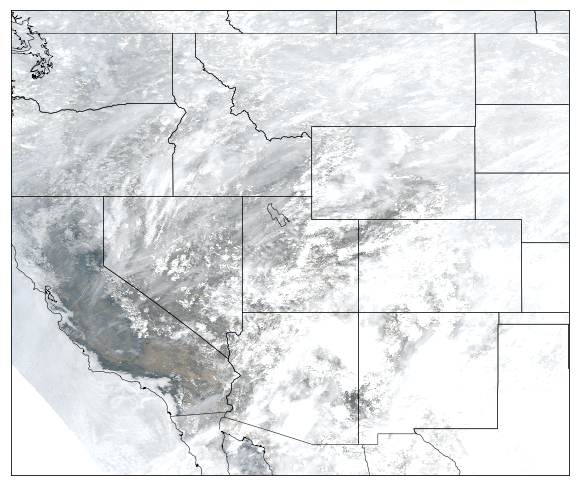

In [15]:
plt.figure(figsize=[10,10])
newmap = w.pcolormesh(ABI['lon'], ABI['lat'], np.zeros_like(ABI['lon']), color=max_composite, linewidth=0, latlon=True)
newmap.set_array(None)
w.drawstates(linewidth=.5)
w.drawcoastlines(linewidth=.5)
w.drawcountries(linewidth=.5)

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


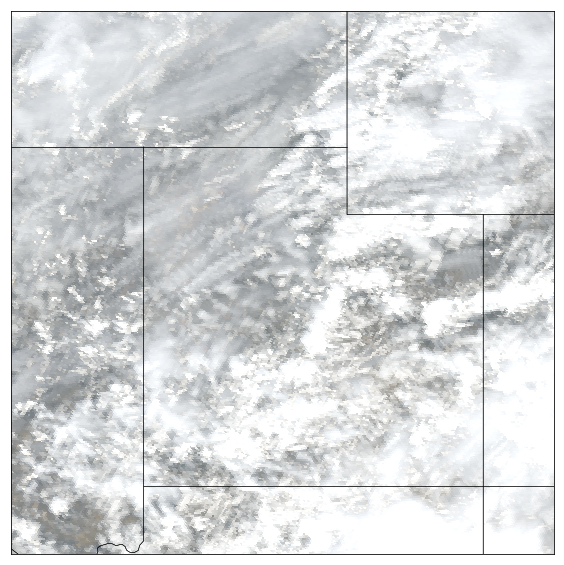

In [16]:
plt.figure(figsize=[10,10])
newmap = u.pcolormesh(ABI['lon'], ABI['lat'], np.zeros_like(ABI['lon']), color=max_composite, linewidth=0, latlon=True)
newmap.set_array(None)
u.drawstates()
u.drawcountries()